In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fpath = '../../results/2021-12-02-proximity-various-ADgenesets/merged-proximity-chembl.csv'
usecols = range(6)
merged = pd.read_csv(fpath, index_col=0, skiprows=1, usecols=usecols).rename_axis('drug_chembl_id', axis=0)

In [3]:
fpath = '../../results/2021-12-02-proximity-various-ADgenesets/merged-proximity-chembl.csv'
sel_gsets = ['knowledge', 'TWAS2+', 'agora2+', 'AD DE APOE3-APOE3', 'AD DE APOE4-APOE4', 'APOE3-4 DE neuron', 'APOE3-4 DE astrocyte', 'APOE3-4 DE microglia']
merged_ranks = pd.read_csv(fpath, index_col=0, header=[0, 1]).rename_axis('drug_chembl_id', axis=0).xs('rank', axis=1, level=1)[sel_gsets]

In [4]:
fpath = '../../results/2021-12-13-chembl-drug-info/drug-indication.csv'
indications = pd.read_csv(fpath, index_col='drug_chembl_id')
# D000544 is Alzheimer disease
mp4ad = indications.loc[indications.mesh_id == 'D000544', ['max_phase_for_ind']].rename({'max_phase_for_ind': 'max_phase_for_AD'}, axis=1)

In [5]:
fpath = '../../results/2021-12-13-chembl-drug-info/drug-info-bbb.csv'
info_bbb = pd.read_csv(fpath, index_col=0).drop(['drug_name'], axis=1)

In [6]:
fpath = '../../results/2022-01-14-rank-aggregation/aggregated-ranks.csv'
agg_ranks = pd.read_csv(fpath, index_col='rank')
top_drugs = pd.DataFrame({'aggregate rank': agg_ranks.index}, index=agg_ranks.MC3).rename_axis('drug_chembl_id', axis=0)

In [7]:
drugs = pd.merge(merged, info_bbb, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, mp4ad, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, top_drugs, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, merged_ranks, how='left', on='drug_chembl_id')
drugs = drugs.sort_values('aggregate rank')
drugs.to_csv('../../results/2022-01-14-top-drugs/ranked-drugs.csv')
drugs.iloc[:200].to_csv('../../results/2022-01-14-top-drugs/ranked-drugs-top-200.csv')

In [8]:
def top_bottom(drugs=drugs, topk=100, min_max_phase_for_AD=1, ind_col='max_phase_for_AD'):
    bottoml = drugs['aggregate rank'].count()
    #bottomk = len(drugs) - topk
    df = drugs.copy()
    df['tested4AD'] = drugs.max_phase_for_AD >= min_max_phase_for_AD
    top = df.iloc[:topk]
    bottom = df.iloc[-bottoml:]
    top_avg, bottom_avg = [df.loc[df['tested4AD'], ind_col].sum() / xk for df, xk in zip([top, bottom], [topk, bottoml])]
    ratio = top_avg / bottom_avg
    return(ratio)

Let $X$ denote the top-$k$ drugs or the bottom $l$ drugs.  Definition of **average phase for AD** for drugs in $X$:
\begin{eqnarray}
\bar{\phi_X} &=& \frac{1}{|X|} \sum_{d \in X} \phi_d \\
|X| &=& 
  \begin{cases} 
   k   & \text{if } X = \text{top-}k \text{ drugs} \\
   l & \text{if } X = \text{bottom-}l \text{ drugs}
  \end{cases}
\end{eqnarray}

Definition of **top:bottom phase ratio for AD**:
\begin{equation}
\frac{\bar{\phi}_{\text{top-}k \text{ drugs}}}{\bar{\phi}_\text{bottom drugs}}
\end{equation}

#### Notes

* the top $0 < k \le n_\text{max agg rank} = 605$ may be adjusted to see the effect of $k$ on the top:bottom phase ratio for AD; see graph below
* the bottom $l$ is fixed at $l = n_\text{all drugs} - n_\text{max agg rank} = 1808$, see code block below

In [9]:
print('bottom l drugs:', len(drugs['aggregate rank']) - drugs['aggregate rank'].count())

bottom l drugs: 1808


['named-figure/top-bottom-ratio-top-k.png',
 'named-figure/top-bottom-ratio-top-k.pdf']

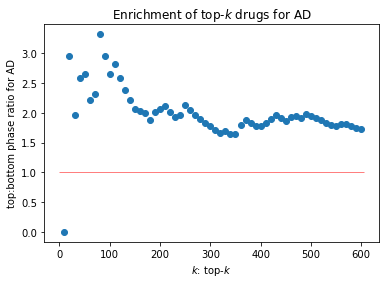

In [10]:
def top_bottom_plot(ax, drugs, min_max_phase_for_AD=1, ind_col='max_phase_for_AD', title=None):
    step = 10
    topks = np.arange(start=step, stop=len(agg_ranks), step=step)
    ORs = [top_bottom(drugs, topk=k, min_max_phase_for_AD=min_max_phase_for_AD, ind_col=ind_col) for k in topks]
    ax.scatter(x=topks, y=ORs)
    ax.set_xlabel(r'$k$: top-$k$')
    ax.set_ylabel('top:bottom phase ratio for AD')
    title = ind_col if title is None else title
    ax.set_title(ind_col)
    ax.hlines(1, 0, len(agg_ranks), color='red', linewidth=0.5)
    return(ax)

fig, ax = plt.subplots()
ax = top_bottom_plot(ax, drugs, min_max_phase_for_AD=1, ind_col='max_phase_for_AD')
ax.set_title(r'Enrichment of top-$k$ drugs for AD')
attila_utils.savefig(fig, 'top-bottom-ratio-top-k')

## More indications

In [11]:
fpath = '../../results/2021-12-13-chembl-drug-info/drug-mesh.csv'
mesh = pd.read_csv(fpath, index_col=['drug_chembl_id', 'mesh_id']).sort_index(0, level='mesh_id').dropna()
# remove rare indications
min_freq_ind = 100
mesh_id_freq = mesh.index.get_level_values('mesh_id').value_counts()
common_ind = set(mesh_id_freq.loc[mesh_id_freq >= min_freq_ind].index)
rare_ind = set(mesh_id_freq.index).difference(common_ind)
mesh = mesh.drop(rare_ind, axis=0, level='mesh_id')
# remove unscreened drugs
#drugs2remove = set(mesh.index.get_level_values('drug_chembl_id')).difference(set(drugs.index))
#mesh = mesh.drop(drugs2remove, axis=0, level='drug_chembl_id')
mesh

,,drug_name,mesh_heading,max_phase_for_ind
drug_chembl_id,mesh_id,,,
CHEMBL1017,D000544,TELMISARTAN,Alzheimer Disease,2.0
CHEMBL1023,D000544,BEXAROTENE,Alzheimer Disease,2.0
CHEMBL103,D000544,PROGESTERONE,Alzheimer Disease,3.0
CHEMBL10316,D000544,IDAZOXAN,Alzheimer Disease,0.0
CHEMBL106,D000544,FLUCONAZOLE,Alzheimer Disease,1.0
...,...,...,...,...
CHEMBL940,D064129,GABAPENTIN,"Prostatic Neoplasms, Castration-Resistant",2.0
CHEMBL94657,D064129,PATUPILONE,"Prostatic Neoplasms, Castration-Resistant",2.0
CHEMBL960,D064129,LEFLUNOMIDE,"Prostatic Neoplasms, Castration-Resistant",2.0


In [12]:
mesh_phase = mesh.max_phase_for_ind.unstack()
drugs_mesh = pd.merge(drugs, mesh_phase, how='left', on='drug_chembl_id')
drugs_mesh

,drug_name,max_phase,indication_class,uniprot_name,target_name,standard_inchi,logBB,BBB+/BBB-,BBB confidence group,max_phase_for_AD,...,D010190,D010300,D011471,D012509,D012559,D015179,D015470,D015658,D045169,D064129
drug_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL491473,CEDIRANIB,3,NaN,CDC7|PK3CD|EF2K|PLK4|STK25|P3C2B|RIOK3|MP2K7|I...,Cell division cycle 7-related protein kinase|P...,InChI=1S/C25H27FN4O3/c1-16-12-17-19(29-16)6-7-...,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,2.0,1.0,NaN,NaN,2.0
CHEMBL477772,PAZOPANIB,4,NaN,BMR1B|PK3CD|PLK4|STK25|P3C2B|RIOK3|MP2K7|CHK1|...,Bone morphogenetic protein receptor type-1B|PI...,InChI=1S/C21H23N7O2S/c1-13-5-6-15(11-19(13)31(...,NaN,NaN,NaN,NaN,...,2.0,NaN,2.0,3.0,NaN,1.0,2.0,NaN,NaN,2.0
CHEMBL446452,ARUNDINE,3,NaN,RGS4|GPR84,Regulator of G-protein signaling 4|G-protein c...,InChI=1S/C17H14N2/c1-3-7-16-14(5-1)12(10-18-16...,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL296306,LACTULOSE,4,Laxative,RGS4,Regulator of G-protein signaling 4,InChI=1S/C12H22O11/c13-1-4-6(16)7(17)8(18)11(2...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL1193,PHENIRAMINE,4,NaN,RGS4,Regulator of G-protein signaling 4,InChI=1S/C16H20N2/c1-18(2)13-11-15(14-8-4-3-5-...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL236593,TELCAGEPANT,3,NaN,RAMP1|CALCA|CALRL,"Calcitonin-gene-related peptide receptor, CALC...",InChI=1S/C26H27F5N6O3/c27-18-4-1-3-17(21(18)28...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL3716057,GEFAPIXANT,3,NaN,P2RX3|P2RX2,P2X purinoceptor 3|P2X2/P2X3 heterotrimeric re...,InChI=1S/C14H19N5O4S/c1-7(2)8-4-10(22-3)12(24(...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL770,TOLAZOLINE,4,Vasodilator (peripheral),LMNA|CP1A2|ADA1D|5HT1D|5HT1B|ADA1A|ADA1B|TAAR1,Prelamin-A/C|Cytochrome P450 1A2|Adrenergic re...,InChI=1S/C10H12N2/c1-2-4-9(5-3-1)8-10-11-6-7-1...,NaN,BBB+,C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<ipython-input-8-b17d7eddeb53>:9: RuntimeWarning: invalid value encountered in double_scalars
  ratio = top_avg / bottom_avg
<ipython-input-8-b17d7eddeb53>:9: RuntimeWarning: invalid value encountered in double_scalars
  ratio = top_avg / bottom_avg
<ipython-input-8-b17d7eddeb53>:9: RuntimeWarning: invalid value encountered in double_scalars
  ratio = top_avg / bottom_avg
<ipython-input-8-b17d7eddeb53>:9: RuntimeWarning: invalid value encountered in double_scalars
  ratio = top_avg / bottom_avg
<ipython-input-8-b17d7eddeb53>:9: RuntimeWarning: invalid value encountered in double_scalars
  ratio = top_avg / bottom_avg
<ipython-input-8-b17d7eddeb53>:9: RuntimeWarning: invalid value encountered in double_scalars
  ratio = top_avg / bottom_avg
<ipython-input-8-b17d7eddeb53>:9: RuntimeWarning: invalid value encountered in double_scalars
  ratio = top_avg / bottom_avg
<ipython-input-8-b17d7eddeb53>:9: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = top_avg / bottom_avg

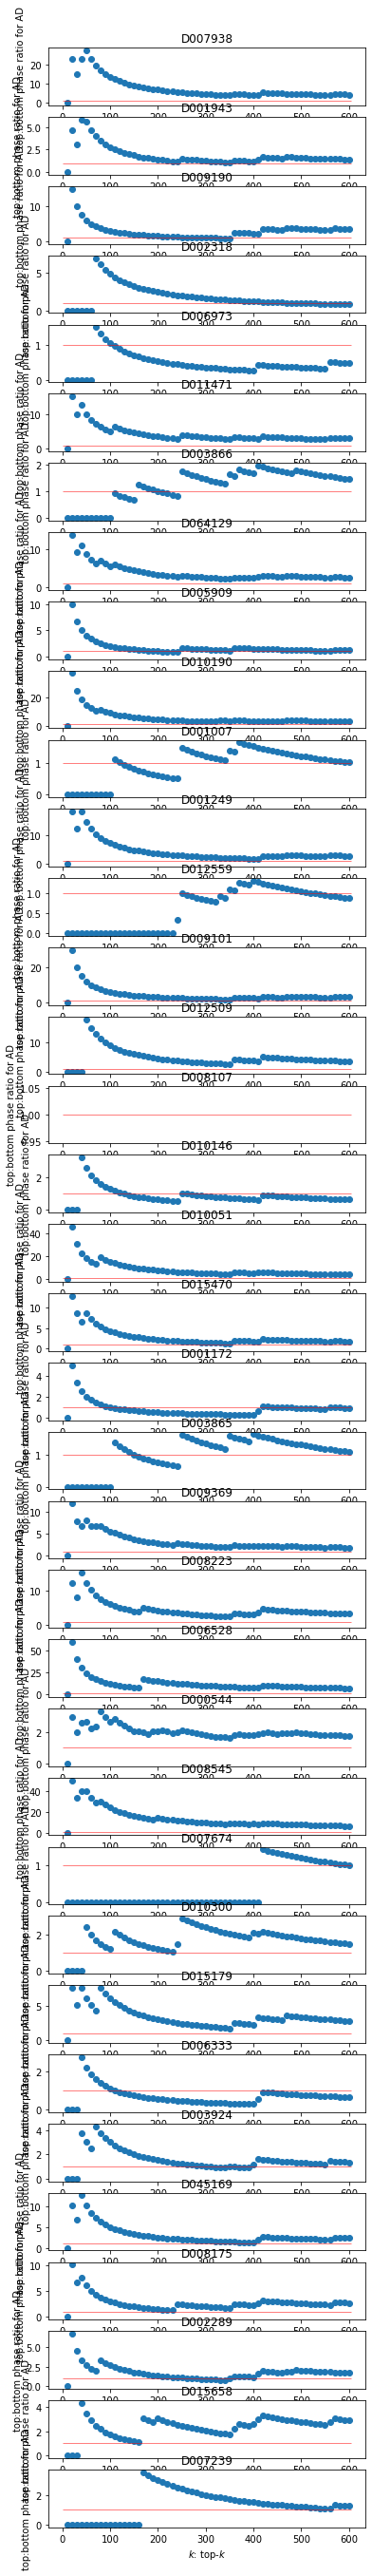

In [13]:
fig, ax = plt.subplots(len(common_ind), 1, figsize=(6, 48))
for axi, ind in zip(ax, common_ind):
    axi = top_bottom_plot(axi, drugs_mesh, min_max_phase_for_AD=1, ind_col=ind, title=None)

In [14]:
%connect_info

{
  "shell_port": 52124,
  "iopub_port": 52125,
  "stdin_port": 52126,
  "control_port": 52128,
  "hb_port": 52127,
  "ip": "127.0.0.1",
  "key": "837b22aa-6284b7c393e08a165b23190e",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-9dc2acaa-dd9e-47f8-8473-80bf157cbe8e.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
